In [1]:
import data
from attention import AttentionLayer

In [2]:
from tqdm import tqdm

In [2]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [3]:
import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup 
from nltk.corpus import stopwords   
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [4]:
CData = data.read_csv(clean=True)
CData.dropna(axis=0,inplace=True)
#CData = CData.replace(np.nan, '', regex=True)

In [6]:
#CData['Category'] = CData['Category'].replace('af other', 'afother')
#CData['Category'] = CData['Category'].replace('dug up', 'dugup')
#CData['Category'] = CData['Category'].replace('oh cable', 'ohcable')
#CData['Category'] = CData['Category'].replace('ug cable', 'ugcable')

In [5]:
CData

IncidentDatetime  \
3        7/10/2010 0:00   
4       5/07/2012 13:08   
5       26/11/2013 6:51   
6        3/06/2013 4:48   
7       5/07/2013 21:17   
63       6/07/2015 9:35   
88     24/12/2012 20:03   
97      4/01/2015 10:00   
116    15/07/2015 23:38   
162     25/01/2015 4:00   
182     3/01/2015 14:35   
220    12/07/2015 16:16   
224    11/02/2015 23:06   
246    13/02/2015 16:51   
248     21/01/2015 6:27   
267     2/07/2015 19:09   
296    19/01/2015 18:25   
306     25/09/2010 0:00   
307     17/01/2012 0:00   
308     4/05/2014 21:40   
369     5/01/2015 22:07   
370    25/02/2015 14:35   
378     7/01/2015 17:08   
413    20/02/2015 14:31   
455     7/01/2015 16:30   
470     26/01/2015 8:29   
498     3/01/2015 14:27   
506      4/06/2010 0:00   
507      7/03/2011 0:00   
509      1/03/2012 0:00   
...                 ...   
14981   21/10/2019 9:20   
14982  21/10/2019 21:25   
14983   22/10/2019 8:21   
14984  22/10/2019 23:20   
14985   28/10/2019 1:53   
14986   28/10/2019 4:55   
14987   29/10/2019 0:00   
14988  29/10/2019 21:04   
14989   30/10/2019 1:24   
14990   30/10/2019 4:16   
14991    3/11/2019 5:00   
14992  11/11/2019 22:46   
14993  12/11/2019 22:27   
14994   13/11/2019 2:28   
14995   21/11/2019 9:49   
14996   30/11/2019 9:39   
14997    2/12/2019 3:05   
14998    8/12/2019 1:57   
14999   8/12/2019 21:34   
15000    9/12/2019 0:06   
15001   12/12/2019 6:32   
15002  13/12/2019 22:45   
15003   14/12/2019 9:10   
15004   18/12/2019 2:42   
15005   20/12/2019 3:00   
15006  26/12/2019 23:30   
15007   30/12/2019 6:09   
15008  10/12/2019 23:00   
15009   22/12/2019 8:57   
15010   13/12/2019 9:37   

                                                                                                                                                                                                 IncidentCause  \
3                                                                                                                                                                                                    line down   
4                                                                                                            PROPERTY DAMAGE - EG... CAR INTO POLE / TRUCK BRINGING DOWN LINE NOT INVOLVING PRIORITY 1 OUTCOME   
5                                                                                                                                                        Incident at Balmoral Rd, cnr Kimberly Rd, WARRNAMBOOL   
6                                                                                                                                                          Incident at Murchison Rd, cnr Station St, Murchison   
7                                                                                                                         Vehicle impact caused HV injection at Midland Highway, cnr Watson Street, Shepparton   
63                                                                                                                                                             Incident at 128 Pearson St, Brunswick West,3055   
88                                                                                                                                                                POLE FIRE - NOT INVOLVING PRIORITY 1 OUTCOME   
97                                                                                                                                                                   INCIDENT AT 204 BACCHUS MARSH ROAD, CORIO   
116                                                                                                                                                                    Incident at 5 Byrne St, Deer Park. 3023   
162                                                                                                                                                     Pole Fire 3557 MAROONA-GLENTHOMPSON ROAD, GLENTHOMPSON   
182                   

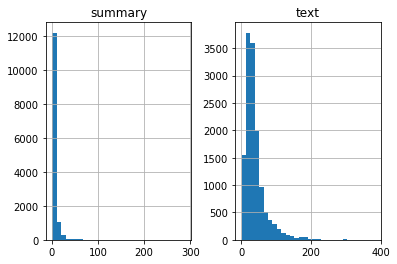

In [6]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in CData['cleaned_description']:
      text_word_count.append(len(i.split()))

for i in CData['cleaned_incident']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [12]:
cnt=0
for i in CData['cleaned_description']:
    if(len(i.split())<=90):
        cnt=cnt+1
print(cnt/len(CData['cleaned_description']))

0.9320452059788553


In [14]:
cnt=0
for i in CData['cleaned_incident']:
    if(len(i.split())<=14):
        cnt=cnt+1
print(cnt/len(CData['cleaned_incident']))

0.9380969741159315


In [15]:
max_len_desc=90
max_len_cause=14

In [16]:
CData['cleaned_incident'] = CData['cleaned_incident'].apply(lambda x : 'sostok '+ x + ' eostok')

In [17]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val,z_tr,z_val=train_test_split(CData['cleaned_description'],CData['cleaned_incident'],CData['Category'],test_size=0.1,random_state=0,shuffle=True)

In [18]:
#prepare a tokenizer for description on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

In [19]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 66.41629351437238
Total Coverage of rare words: 2.718533072461916


In [20]:
#prepare a tokenizer for description on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_len_desc, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_len_desc, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [21]:
x_voc

4651

In [22]:
#preparing a tokenizer for cause on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

In [23]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 79.84338747099768
Total Coverage of rare words: 8.892740483967735


In [24]:
#prepare a tokenizer for cause on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_len_cause, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_len_cause, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [25]:
#check whether word count of start token is equal to length of the training data
y_tokenizer.word_counts['sostok'],len(y_tr), len(z_tr)

(12343, 12343, 12343)

In [39]:
'''#delete rows with only start and end token
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)'''

In [ ]:
'''ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)'''

In [26]:
from keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_len_desc,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 90)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 90, 100)      465100      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 90, 300), (N 481200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [27]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [28]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [29]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=16,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Train on 12343 samples, validate on 1372 samples
Epoch 1/16
12343/12343 [==============================] - 692s 56ms/sample - loss: 2.7023 - val_loss: 2.2635
Epoch 2/16
12343/12343 [==============================] - 786s 64ms/sample - loss: 2.1258 - val_loss: 2.0503
Epoch 3/16
12343/12343 [==============================] - 786s 64ms/sample - loss: 1.9271 - val_loss: 1.9077
Epoch 4/16
12343/12343 [==============================] - 810s 66ms/sample - loss: 1.8180 - val_loss: 1.8238
Epoch 5/16
12343/12343 [==============================] - 828s 67ms/sample - loss: 1.7271 - val_loss: 1.7460
Epoch 6/16
12343/12343 [==============================] - 865s 70ms/sample - loss: 1.6447 - val_loss: 1.6873
Epoch 7/16
12343/12343 [==============================] - 870s 70ms/sample - loss: 1.5721 - val_loss: 1.6208
Epoch 8/16
12343/12343 [==============================] - 890s 72ms/sample - loss: 1.5095 - val_loss: 1.5834
Epoch 9/16
12343/12343 [==============================] - 908s 74ms/sample - lo

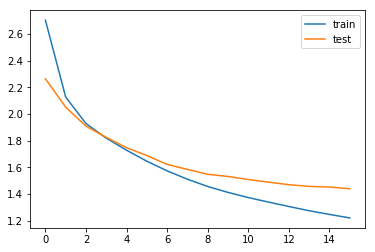

In [30]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [31]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [32]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_desc,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [33]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_len_cause-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [34]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [35]:
def progressBar(current, total, barLength = 20):
    percent = float(current) * 100 / total
    arrow   = '-' * int(percent/100 * barLength - 1) + '>'
    spaces  = ' ' * (barLength - len(arrow))

    print('Progress: [%s%s] %d %%' % (arrow, spaces, percent), end='\r')

In [ ]:
for i in range(120,140):
    print("Description:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_len_desc)))
    print("Category:", list(z_tr)[i])
    print("\n")

In [43]:
tempData = data.read_csv(clean=True)

In [44]:
tempData = tempData[pd.isnull(tempData['IncidentCause'])]

In [45]:
tempData

IncidentDatetime IncidentCause  \
0        4/02/2011 0:00           NaN   
1       17/02/2011 0:00           NaN   
2       16/02/2011 0:00           NaN   
8      18/09/2015 17:20           NaN   
9      23/06/2015 16:43           NaN   
10      1/05/2015 14:00           NaN   
11     20/03/2015 14:08           NaN   
12     21/03/2015 22:18           NaN   
13     30/03/2015 14:12           NaN   
14     30/03/2015 10:24           NaN   
15      1/04/2015 21:57           NaN   
16       2/04/2015 7:50           NaN   
17     21/04/2015 10:17           NaN   
18     20/03/2015 20:37           NaN   
19     29/04/2015 15:00           NaN   
20     29/04/2015 17:02           NaN   
21      11/04/2015 9:25           NaN   
22     18/03/2015 10:05           NaN   
23     27/03/2015 16:00           NaN   
24     27/03/2015 16:48           NaN   
25     20/05/2015 10:00           NaN   
26     21/05/2015 10:30           NaN   
27     18/06/2015 15:14           NaN   
28     21/06/2015 19:23           NaN   
29     25/06/2015 11:20           NaN   
30      27/03/2015 0:20           NaN   
31      2/04/2015 16:32           NaN   
32     10/03/2015 13:27           NaN   
33     16/03/2015 21:14           NaN   
34     26/03/2015 15:08           NaN   
...                 ...           ...   
7745    15/05/2011 0:00           NaN   
7754    21/08/2011 0:00           NaN   
7755    14/12/2011 0:00           NaN   
7758    21/12/2011 0:00           NaN   
7762    12/08/2011 0:00           NaN   
7768    30/01/2010 0:00           NaN   
7769     7/12/2011 0:00           NaN   
7772    29/01/2010 0:00           NaN   
7774    20/02/2012 0:00           NaN   
7779    29/12/2011 0:00           NaN   
7780    23/11/2010 0:00           NaN   
7784    17/08/2011 0:00           NaN   
7785    17/01/2012 0:00           NaN   
7786    26/02/2012 0:00           NaN   
7793    24/02/2012 0:00           NaN   
7801    19/02/2011 0:00           NaN   
7806     5/09/2011 0:00           NaN   
7808    21/02/2011 0:00           NaN   
7821    16/12/2010 0:00           NaN   
7828    10/02/2012 0:00           NaN   
7831     2/12/2010 0:00           NaN   
7838    14/11/2011 0:00           NaN   
7848    11/01/2011 0:00           NaN   
7882    14/07/2011 0:00           NaN   
7883    11/02/2012 0:00           NaN   
7896    24/11/2011 0:00           NaN   
7897    17/08/2011 0:00           NaN   
7904    16/08/2011 0:00           NaN   
10314  14/01/2016 23:55           NaN   
10788   25/03/2016 7:00           NaN   

                                                                                                                                                                                              EventDescription  \
0      SCHEDULE 1<br /> <br /> Fault crew was patrolling RCTS-HTH 66 kV Line and found a 66 kV conductor detached from a broken insulator at the above location, causing it to have a ground clearance of 4...   
1      SCHEDULE TWO<br /> <br /> Mrs Atkinson was dressed and standing on the dry tiled kitchen floor in bare feet when she reached out and touched/made contact with the metal pot simmering on the electr...   
2                                                     SCHEDULE ONE<br /> <br /> Lightning hit tree in street causing appliance damage to houses in vicinity.<br /> <br /> Sent crew to investigate and repair.   
8      ID : 3558074\r\r\r\nPriority: PRIORITY 3 - LOW RISK OR NOT URGENT\r\r\r\nAction Taken: \r\r\r\nComments: WERE REPLACING AN EDO FUSE - IT BLEW AND CAUSED A GRASS FIRE OF APPROX 2FT SQUARE - HAVE FA...   
9      ID : 3077686\r\r\r\nPriority: PRIORITY 2 - LOW RISK OR NOT URGENT\r\r\r\nAction Taken: \r\r\r\nComments: EMPLOYEE WAS RUNNING A NEW GAS SERVICE LINE AND ONE OF THEIR PIECES OF EQUIPMENT APPEARS TO...   
10     Schedule 1\r\r\r\n\r\r\r\nA customer reported that a Eureka concrete truck had brought down a service wire at the above location.  On arrival the crew found that a cement mixer truck (Driver: John.

In [57]:
from sklearn.model_selection import train_test_split
x_tr,x_val,z_tr,z_val=train_test_split(tempData['cleaned_description'],tempData['Category'],test_size=0,random_state=0,shuffle=False)

In [58]:
#prepare a tokenizer for description on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

In [59]:
#prepare a tokenizer for description on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_len_desc, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_len_desc, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [61]:
for i in range(0,30):
    print("Description:",seq2text(x_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_len_desc)))
    print("Category:", list(z_tr)[i])
    print("\n")

Description: crew customer fire process customers service supply garage circuit conducted contact shower conductor council condition rear supply contacting conducted assets protection station rec ground running priority action fuse split tracking volt connector landed electric crossarm completing claim customers cfa split south rise protection pressure piping conductor reports 
Predicted summary:  cause found
Category: lightning


Description: clear connected pollution situation faults load also tree faults protection station excavator injuries isolated report damage left area also cable called impedance underground truck folcb sparks reports services fires compliance clear white truck tree oven termination nst notified nst cfa protection station please slight tree wire arm water injection burning stop falling cable email current hit form employee operations found received within ground injuries isolated injection report damage left area cable called truck attempted conditions strip no

Predicted summary:  tree fell onto overhead conductor
Category: connection


Description: shock shock arrival occurred box phase connection complete entering hill going taken incident identified termination candled pole waste priority tests 
Predicted summary:  cause found
Category: vehicle


Description: shock shock arrival occurred box phase connection complete low injuries earth pole corroded reported conductor reported priority wet serious procedures vandals 
Predicted summary:  cause found
Category: fuse


Description: shock shock arrival occurred box phase connection complete low supply distribution one lockout conductor priority received 
Predicted summary:  cause found
Category: conductor


Description: existing came affecting replaced mass cause comments retested away address sub supply incident comments attended fire making water vic melted appliances conductors receiving vegetation revealed enable advised water due low injuries power causing inspector conductors consumers ap

In [63]:
descriptions = []
predicted_cause = []
categories = []
for i in range(len(x_tr)):
    descriptions.append(seq2text(x_tr[i]))
    predicted_cause.append(decode_sequence(x_tr[i].reshape(1,max_len_desc)))
    categories.append(list(z_tr)[i])
    progressBar(i, len(x_tr))

df = pd.DataFrame(descriptions)
df['predicted_cause'] = predicted_cause
df['category'] = categories

df.to_csv(data.DATA_DIR +"predicted_cause.csv", index=False, header=True)

NameError: name 'predicted_summaries' is not defined

In [64]:
df = pd.DataFrame(descriptions)
df['predicted_cause'] = predicted_cause
df['category'] = categories

df.to_csv(data.DATA_DIR +"predicted_cause.csv", index=False, header=True)

In [95]:
df.to_csv(data.DATA_DIR +"textsummarisationtest2.csv", index=False, header=True)

In [ ]:
predicted_summaries = []
for i in range(len(xTest_tr)):
    predicted_summaries.append(decode_sequence(xTest_tr[i].reshape(1,max_len_desc)))
    progressBar(i, len(xTest_tr))

print("Copying...")
TempData['Predicted_summary'] = predicted_summaries
print("Complete")
print("\n")
print("Making csv...")
TempData.to_csv(data.DATA_DIR + '/text_summarisation.csv', index=False, header=True)
print("Complete")